                                   ***Youtube trends analysis from local data warehouse***                                                                               
                                            BY : Abdullah Mahdy



- First : Data extraction then explaratory data analysis 
            to show different categories views for each country dataframe


 
The data model for each country :

- Video (CSV)
        
        video_id (PK) ,title , channel_title , publish_time , tags , views , likes ,
        dislikes , comment_count , trending_date , category_id (FK → Category)
        




- Category (JSON)


        category_id (PK)
        category_name


In [15]:
import pandas as pd
import json
import matplotlib.pyplot as plt

* The pipeline

    data handling for explaratory data analysis 

In [16]:
def data_transform(x : str) -> pd.DataFrame:

    df_trends = pd.read_csv(f'D:\\youtube trends\\data\\{x}videos.csv' , encoding='latin1')

    # Extracting from json
    with open(f'D:\\youtube trends\\data\\{x}_category_id.json', 'r') as file:
        data = json.load(file)
    df_catigories = []
    for i in data['items']:
        df_catigories.append((i['id'],i['snippet']['title']))


    df_catigories = pd.DataFrame(df_catigories, columns= ['category_id','category'])
    df_catigories = df_catigories.astype({'category_id':'int64'}) # type casting to join on same dtype
    df_trends = df_trends[['category_id','views']] # DataFrame modification
    df_top_views = pd.merge(df_trends,df_catigories, on='category_id', how='inner')[['category','views']] # Joining tables
    df = df_top_views.groupby('category').sum('views').sort_values(by='views', ascending=True) # trends_views stats
    
    return df.reset_index()



  * Data extraction

     data ingestion for each country data frame

In [17]:
countries = ['US', 'RU', 'CA', 'FR', 'IN', 'JP', 'MX', 'DE']
top_views = {}

for country in countries:
    try:
        top_views[f"{country}_top_views"] = data_transform(country)
    except Exception as e:
        print(f"Error processing {country}: {e}")

# Example: Access Mexico's data
Mexico_top_views = top_views["MX_top_views"]

Mexico_top_views

,category,views
0,Shows,65436
1,Travel & Events,15413050
2,Education,43205309
3,Pets & Animals,45629022
4,Autos & Vehicles,49190861
5,Science & Technology,202863454
6,Gaming,421961773
7,Film & Animation,461919619
8,Howto & Style,465587429
9,News & Politics,491449042


Showing visual representations

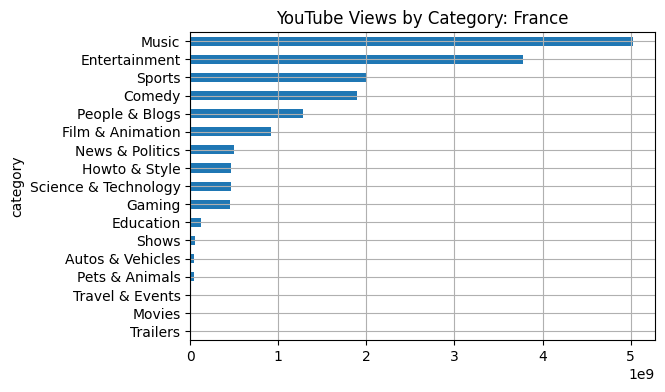

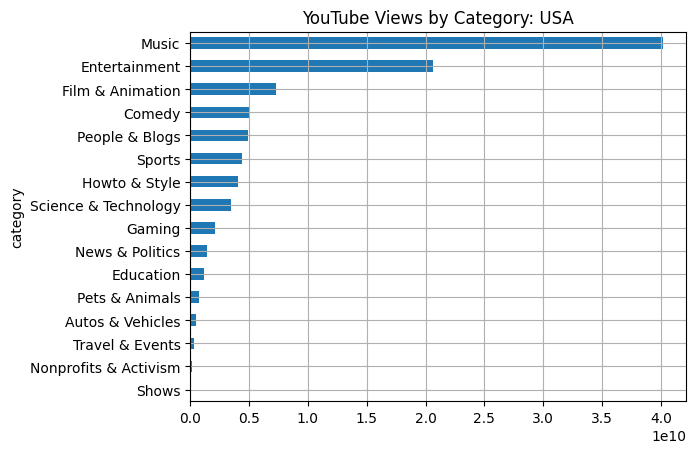

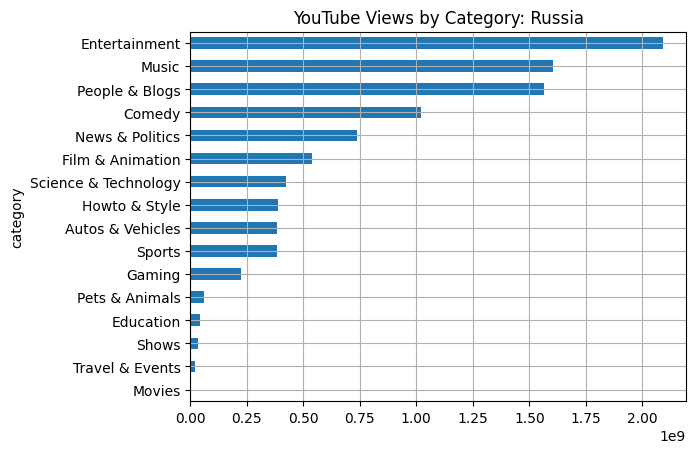

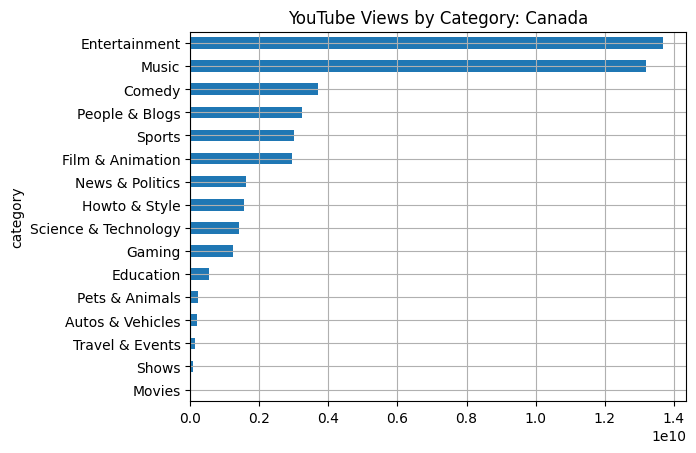

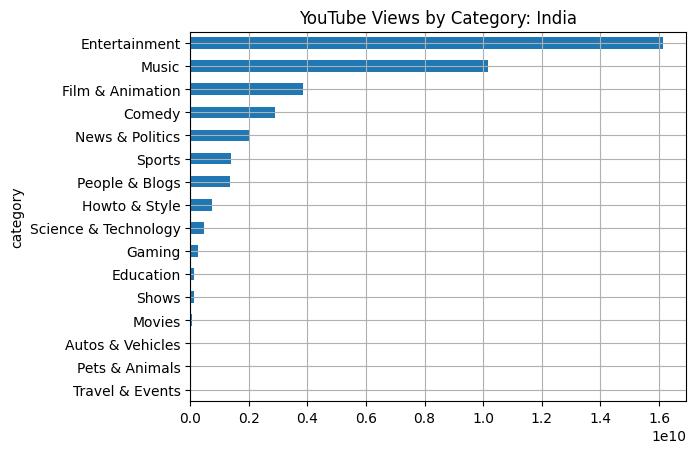

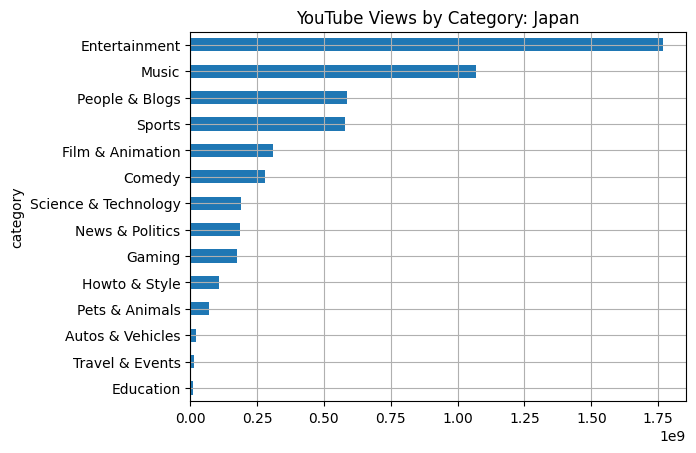

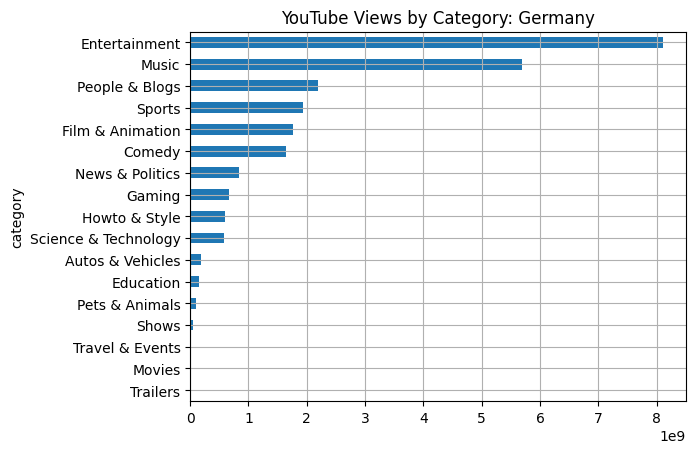

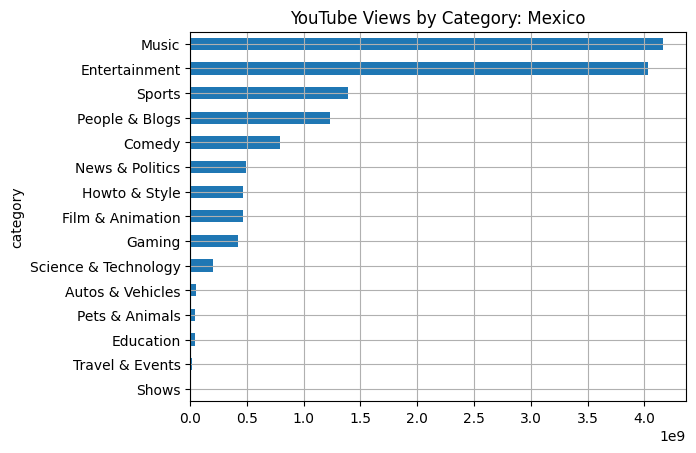

In [18]:
plt.figure(figsize=(6, 4))

countries = {
    'FR': 'France',
    'US': 'USA',
    'RU': 'Russia',
    'CA': 'Canada',
    'IN': 'India',
    'JP': 'Japan',
    'DE': 'Germany',
    'MX': 'Mexico'
}

for country_code, country_name in countries.items():
    if country_code == 'MX':
        df = Mexico_top_views  # Handle Mexico's special case
    else:
        df = top_views[f"{country_code}_top_views"]
    
    df.set_index('category')['views'].plot(
        kind='barh',
        title=f'YouTube Views by Category: {country_name}',
        grid=True
    )
    plt.show()

- Second : Machine learning model to predect number of views from comments,likes,and dislikes

In [19]:
def ML_data_transform(x : str) -> pd.DataFrame:

    df_trends = pd.read_csv(f'D:\\youtube trends\\data\\{x}videos.csv' , encoding='latin1')

    # Extracting from json
    with open(f'D:\\youtube trends\\data\\{x}_category_id.json', 'r') as file:
        data = json.load(file)
    df_catigories = []
    for i in data['items']:
        df_catigories.append((i['id'],i['snippet']['title']))


    df_catigories = pd.DataFrame(df_catigories, columns= ['category_id','category'])
    df_catigories = df_catigories.astype({'category_id':'int64'}) # type casting to join on same dtype
    df_trends = df_trends[['category_id','views','comment_count','likes','dislikes']] # DataFrame modification
    df_top_views = pd.merge(df_trends,df_catigories, on='category_id', how='inner')[['category','views','comment_count','likes','dislikes']] # Joining tables
    df = df_top_views.groupby('category').sum('views').sort_values(by='views', ascending=True) # trends_views stats
    
    return df.reset_index()

In [20]:
countries = ['US', 'RU', 'CA', 'FR', 'IN', 'JP', 'MX', 'DE']
ML_top_views = {}

for country in countries:
    try:
        ML_top_views[f"{country}_top_views"] = ML_data_transform(country)
    except Exception as e:
        print(f"Error processing {country}: {e}")

# Example: Access Mexico's data
ML_Mexico_top_views = ML_top_views["MX_top_views"]

ML_Mexico_top_views

,category,views,comment_count,likes,dislikes
0,Shows,65436,331,491,91
1,Travel & Events,15413050,103758,897709,26253
2,Education,43205309,295654,2550632,67408
3,Pets & Animals,45629022,166061,990508,63713
4,Autos & Vehicles,49190861,368109,2980893,83752
5,Science & Technology,202863454,881509,5114569,275862
6,Gaming,421961773,2887305,24002503,938239
7,Film & Animation,461919619,2048173,17915248,516653
8,Howto & Style,465587429,3682138,24651100,792362
9,News & Politics,491449042,2328675,11910414,957379


In [21]:
# 1. Combine all DataFrames (including Mexico)
all_dfs = [
    ML_top_views["US_top_views"],
    ML_top_views["RU_top_views"], 
    ML_top_views["CA_top_views"],
    ML_top_views["FR_top_views"],
    ML_top_views["IN_top_views"],
    ML_top_views["JP_top_views"],
    ML_top_views["DE_top_views"],
    ML_top_views["MX_top_views"]
]

# 2. Standardize categories and sum all numeric columns
total_df = pd.concat(all_dfs) \
            .groupby('category', as_index=False) \
            .sum(numeric_only=True)

# 3. Show result (sorted by total views)
total_df = total_df.sort_values('views', ascending=False)
print(total_df)

                 category        views  comment_count       likes   dislikes
8                   Music  81009232343      296466964  3243965921  128975866
3           Entertainment  70160719329      273361492  2025243165  152302378
4        Film & Animation  18059806494       47059681   425974031   18456630
1                  Comedy  17348962454       90317750   924909650   35532928
11         People & Blogs  16365709817       77950834   535824527   43632785
15                 Sports  15070258643       36030396   320547365   16400284
6           Howto & Style   8405320104       41446772   292364056   11022840
9         News & Politics   7840606753       31841838   118939892   23763496
13   Science & Technology   7244533534       42444638   215395246   10374804
5                  Gaming   5592342120       37907876   218424966   16902581
2               Education   2217086288       11628693    98794014    3063637
0        Autos & Vehicles   1433285193        5411777    41766215    2277197

 Comparing Views, Likes & Comments Across Categories (correlation check)

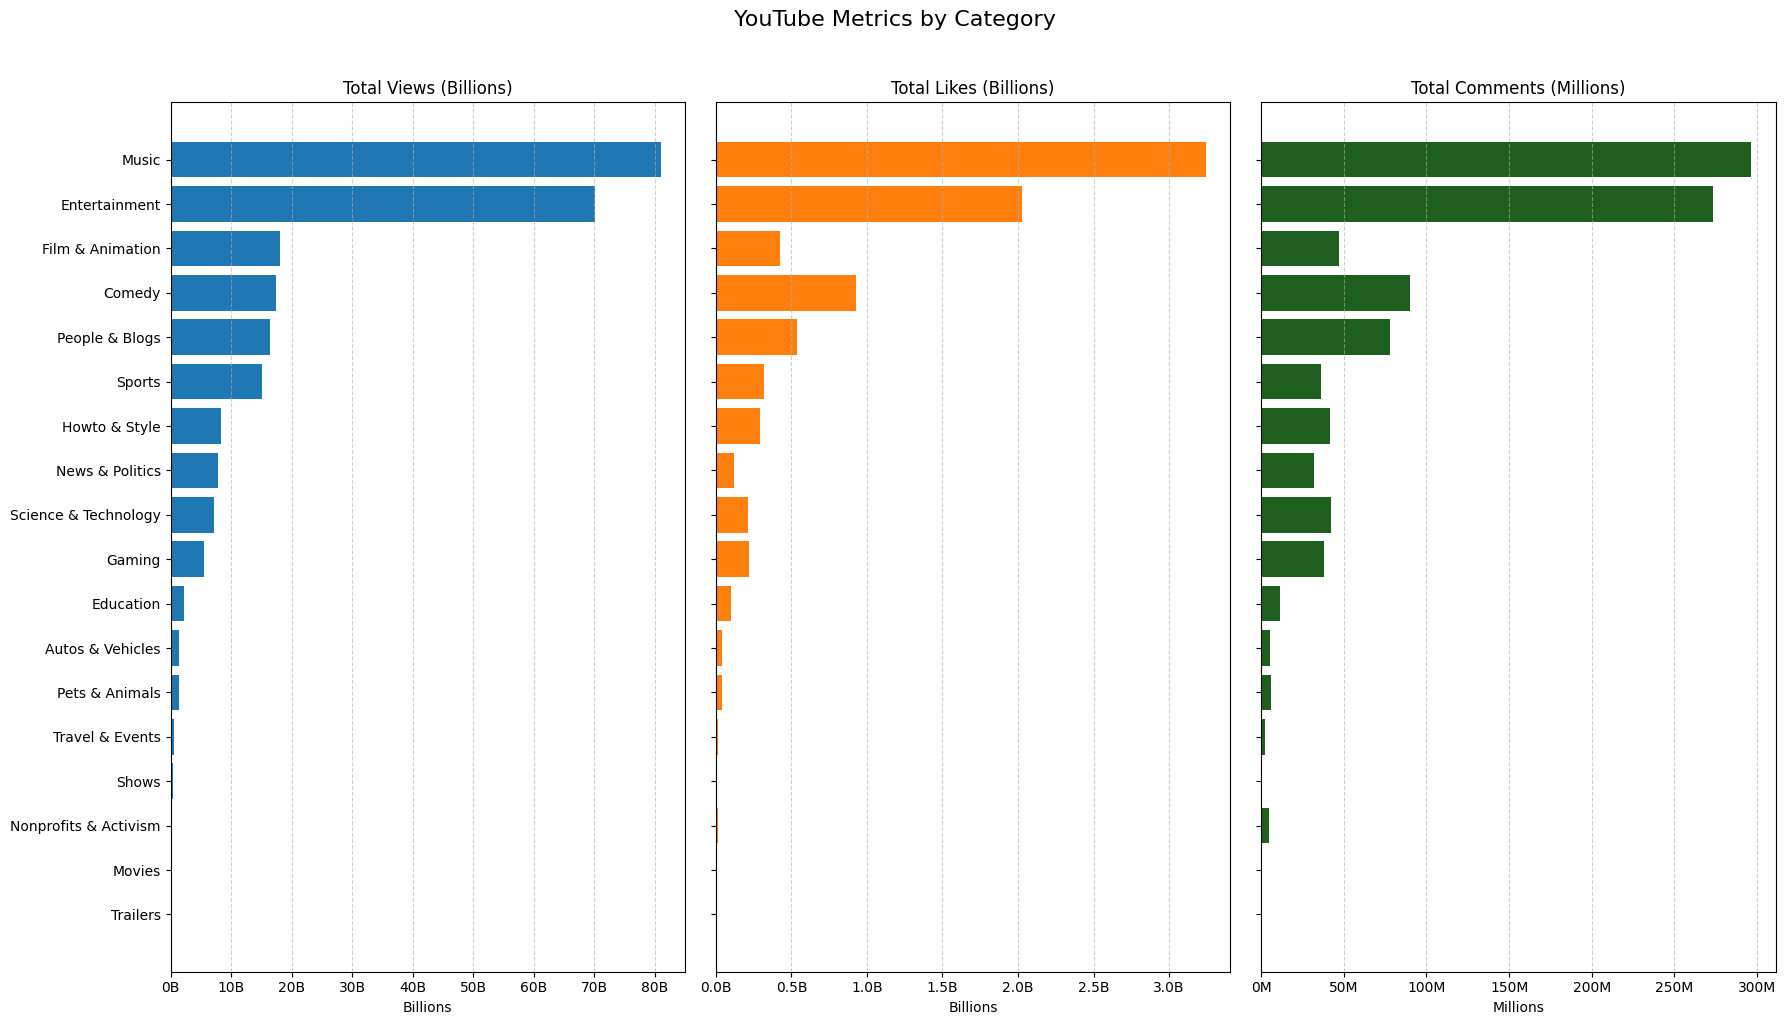

In [22]:

categories = total_df['category'].values
views = total_df['views'].values / 1e9  # Convert to billions
likes = total_df['likes'].values / 1e9  # Convert to billions
comments = total_df['comment_count'].values / 1e6  # Convert to millions

# Set up the figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 10), sharey=True)

# Plot 1: Views
ax1.barh(categories, views, color='#1f77b4')
ax1.set_title('Total Views (Billions)')
ax1.set_xlabel('Billions')
ax1.xaxis.set_major_formatter(lambda x, _: f'{x:.0f}B')

# Plot 2: Likes
ax2.barh(categories, likes, color='#ff7f0e')
ax2.set_title('Total Likes (Billions)')
ax2.set_xlabel('Billions')
ax2.xaxis.set_major_formatter(lambda x, _: f'{x:.1f}B')

# Plot 3: Comments
ax3.barh(categories, comments, color="#1E5E1E")
ax3.set_title('Total Comments (Millions)')
ax3.set_xlabel('Millions')
ax3.xaxis.set_major_formatter(lambda x, _: f'{x:.0f}M')

# Common settings
for ax in [ax1, ax2, ax3]:
    ax.invert_yaxis()  # Highest at top
    ax.grid(axis='x', linestyle='--', alpha=0.6)

plt.suptitle('YouTube Metrics by Category', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

Compining all the data (union) for ML work

In [23]:
# 1. Combine all DataFrames
all_dfs = [
    ML_top_views["US_top_views"],
    ML_top_views["RU_top_views"], 
    ML_top_views["CA_top_views"],
    ML_top_views["FR_top_views"],
    ML_top_views["IN_top_views"],
    ML_top_views["JP_top_views"],
    ML_top_views["DE_top_views"],
    ML_top_views["MX_top_views"]
]
# 2. Add country identifier to each DataFrame before concatenating
countries = ['US', 'RU', 'CA', 'FR', 'IN', 'JP', 'DE', 'MX']
for df, country in zip(all_dfs, countries):
    df['country'] = country  # Add country column

# 3. Concatenate vertically (union)
combined_df = pd.concat(all_dfs, ignore_index=True)

# 4. Result (all rows preserved)
print(combined_df.head() , '\n\n')
print('shape of df' , combined_df.shape)

                category      views  comment_count     likes  dislikes country
0                  Shows   51501058          95117   1082639     24508      US
1  Nonprofits & Activism  168941392        4808797  14815646   3310381      US
2        Travel & Events  343557084         911511   4836246    340427      US
3       Autos & Vehicles  520690717         784447   4245656    243010      US
4         Pets & Animals  764651989        2660705  19370702    527379      US 


shape of df (127, 6)


Importing Sikit-learn methods

In [24]:
from sklearn.linear_model import LinearRegression , Lasso , Ridge
from sklearn.model_selection import train_test_split , KFold
from sklearn.metrics import r2_score, mean_squared_error

In [25]:
combined_df.isnull().sum()

category         0
views            0
comment_count    0
likes            0
dislikes         0
country          0
dtype: int64

Nice there is no nulls !
now let's start the work

Last touch and building the model 

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression


# Prepare regression data
X = combined_df[['likes', 'comment_count']]  # Features
y = combined_df['views']                     # Target variable

# Initialize K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = LinearRegression()

# Store results
r2_scores = []
rmse_scores = []

print("K-Fold Regression Results:")
print("=" * 40)

for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
    # Split data
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Train and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Store scores
    r2_scores.append(r2)
    rmse_scores.append(rmse)
    
    print(f"Fold {fold}: R² = {r2:.3f}, RMSE = {rmse:.2e}")

# Final performance summary
print("=" * 40)
print("FINAL PERFORMANCE SUMMARY:")
print(f"Average R² Score: {np.mean(r2_scores):.3f}")
print(f"Average RMSE: {np.mean(rmse_scores):.2e}")
print(f"R² Score Range: {np.min(r2_scores):.3f} - {np.max(r2_scores):.3f}")

K-Fold Regression Results:
Fold 1: R² = 0.860, RMSE = 1.28e+09
Fold 2: R² = 0.977, RMSE = 1.20e+09
Fold 3: R² = 0.828, RMSE = 6.59e+08
Fold 4: R² = 0.892, RMSE = 1.02e+09
Fold 5: R² = 0.932, RMSE = 1.05e+09
FINAL PERFORMANCE SUMMARY:
Average R² Score: 0.898
Average RMSE: 1.04e+09
R² Score Range: 0.828 - 0.977


Woooooow! I didn't predict that , Very HIGH score (=